In [1]:
import os
import re
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date

In [2]:
working_dir = "/om2/user/ckauf/.result_caching/neural_nlp.score"

In [3]:
#random low-pmi condition missing
categories_perturb = ['original', 'nouns', 'nouns-del50%', 'random-nouns', 'nounsverbs', 'nounsverbsadj', 'contentwords', 'functionwords', 'passageshuffle','random-sent']
categories_scrambled = ['original', 'scrambled1', 'scrambled3', 'scrambled5', 'scrambled7', 'lowpmi', 'backward', 'random-wl']#, random-lowpmi]

categories = [categories_perturb, categories_scrambled]
keys = ["perturb", "scrambled"]

categories_dict = dict(zip(keys, categories))

# Get best model scores

In [4]:
def get_max_score(matrix):
    """
    input: result = out['data'].values matrix (e.g. for distilgpt2 a matrix of dimensions 7x2)
    output: maximum score and associated error for this matrix.
    """
    max_score, error = 0,0
    for i in range(len(matrix)):
        if matrix[i][0] > max_score:
            max_score = matrix[i][0]
            error = matrix[i][1]
    return max_score, error

In [5]:
# #not used currently
# def get_best_score_dict(model_identifier):
#     """
#     input: model_identifier
#     output: dictionary containing the maximum score and associated error per condition.
#             structure of dictionary: condition --> {score --> max_score, error --> associated error}
#     """
#     score_dict = {}
#     for filename in os.listdir(working_dir):
#         model_name = filename.split(",")[1]
#         if "model=" + model_identifier == model_name:
#             if ("-encoding-perturb" in filename) or ("encoding-scrambled" in filename):
#                 condition = filename.split(",")[0].split("Pereira2018-encoding-")[-1]
#                 print(condition)
#                 if not condition in score_dict:
#                     score_dict[condition] = {}
#                 file = os.path.join(working_dir,filename)
#                 with open(file, 'rb') as f:
#                     out = pickle.load(f)
#                 result = out['data'].values
#                 #print(result, '\n\n')
#                 max_score, error = get_max_score(result)
#                 score_dict[condition]['score'] = max_score
#                 score_dict[condition]['error'] = error
#     return score_dict

In [6]:
def get_best_scores_df(model_identifier,categories_dict,scr_perturb=None):
    """
    input: model_identifier
    output: dictionary containing the maximum score and associated error per condition.
            structure of dictionary: condition --> {score --> max_score, error --> associated error}
    """
    conditions = []
    max_scores = []
    errors = []
    
    for filename in os.listdir(working_dir):
        if os.path.isdir(os.path.join(working_dir,filename)):
            continue
        model_name = filename.split(",")[1]
        if "model=" + model_identifier == model_name:
            if (f"-encoding-{scr_perturb}" in filename) or ("-encoding-scrambled-original" in filename):
                
                condition = filename.split(",")[0].split("Pereira2018-encoding-")[-1]
                
                if scr_perturb == "perturb":
                    condition = re.sub("perturb-","",condition)
                    condition = re.sub("scrambled-","",condition)
                    if condition == "randomsentenceshuffle":
                        condition = "random-sent"
                    if condition == "nouns-delete50percent":
                        condition = "nouns-del50%"
                    
                elif scr_perturb == "scrambled":
                    if not any(x in condition for x in ["1", "3", "5", "7"]):
                        condition = re.sub("scrambled-","",condition)
                    else:
                        condition = condition
                #print(condition)

                file = os.path.join(working_dir,filename)
                with open(file, 'rb') as f:
                    out = pickle.load(f)
                result = out['data'].values
                #print(result, '\n\n')
                max_score, error = get_max_score(result)
                
                conditions.append(condition)
                max_scores.append(max_score)
                errors.append(error)
                
    import pandas as pd
    index = conditions
    df = pd.DataFrame({'score': max_scores,
    'error': errors, 'condition': conditions})
    df['condition'] = pd.Categorical(df['condition'], categories=categories_dict[scr_perturb])
    scores_df = df.sort_values(by='condition')
    return scores_df

In [7]:
# def get_last_scores_df(model_identifier):
#     """
#     input: model_identifier
#     output: dictionary containing the last score and associated error per condition.
#             structure of dictionary: condition --> {score --> max_score, error --> associated error}
#     """
#     conditions = []
#     last_scores = []
#     errors = []
#     for filename in os.listdir(working_dir):
#         model_name = filename.split(",")[1]
#         if "model=" + model_identifier == model_name:
#             if ("encoding-perturb" in filename) or ("encoding-scrambled" in filename):
#                 condition = filename.split(",")[0].split("Pereira2018-encoding-")[-1]
#                 condition = re.sub("ablation-","",condition)
#                 condition = re.sub("scrambled-","",condition)

#                 file = os.path.join(working_dir,filename)
#                 with open(file, 'rb') as f:
#                     out = pickle.load(f)
#                 result = out['data'].values
#                 #print(result, '\n\n')
#                 last_score, error = last_score, error = result[-1][0], result[-1][1]
#                 conditions.append(condition)
#                 last_scores.append(last_score)
#                 errors.append(error)
#     import pandas as pd
#     index = conditions
#     df = pd.DataFrame({'score': last_scores,
#     'error': errors, 'condition': conditions})
#     df['condition'] = pd.Categorical(df['condition'], categories=['original', 'nouns', 'nounsverbs', 'nounsverbsadj', 'contentwords', 'functionwords', 'passageshuffle','nouns-delete50percent','random-lowPMI','random-nouns'])
#     #df['condition'] = pd.Categorical(df['condition'], categories=['original', 'scrambled1', 'scrambled3', 'scrambled5', 'scrambled7', 'lowpmi', 'backward', 'random'])
#     scores_df = df.sort_values(by='condition')
#     return scores_df

In [8]:
#function check
scores_df = get_best_scores_df("distilgpt2",categories_dict,scr_perturb="scrambled")
scores_df

Loading lookup from /om2/user/ckauf/anaconda/envs/perturbedenv/lib/python3.6/site-packages/brainio_collection/lookup.csv


,score,error,condition
2,0.852923,0.070897,original
4,0.874679,0.042050,scrambled1
5,0.872582,0.036818,scrambled3
6,0.860335,0.043322,scrambled5
7,0.886425,0.096339,scrambled7
1,0.827481,0.069628,lowpmi
0,0.794462,0.075474,backward
3,0.712206,0.096953,random-wl


# Prepare plotting

In [9]:
def bar_plot(model_identifier, scores_df, scr_perturb=None):
    colors = sns.color_palette("rocket")
    x_pos = np.arange(len(scores_df))
    scores = scores_df['score']
    errors = scores_df['error']
    conditions = scores_df['condition']
    fig, ax = plt.subplots()
    ax.bar(x_pos, scores,
       yerr=errors,
       align='center',
       alpha=0.8, #color intensity
       ecolor='black',
       capsize=5, #error bar width
       color=colors[1]) #if you put just color=colors, you get the bar plots in different rocket palette colors
    ax.set_ylabel('ceiled score',fontsize=12)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(conditions, rotation=60)
    
    if len(model_identifier.split("-")) == 1:
        model_identifier += "-lasttoken"
    ax.set_title('{}'.format(model_identifier),fontsize=18)
    ax.yaxis.grid(True)
    ax.set_ylim([0,1])
    
    if not os.path.isdir("fig"):
        os.mkdir("fig")
    savename = f'fig/{date.today()}_match-to-brain_{scr_perturb}_{model_identifier}.png'
    plt.savefig(savename, bbox_inches='tight', dpi=240)
    plt.show()

In [10]:
def main_plot(model_identifier,categories_dict,scr_perturb="scrambled"):
    scores_df = get_best_scores_df(model_identifier,categories_dict,scr_perturb=scr_perturb)
    bar_plot(model_identifier,scores_df,scr_perturb=scr_perturb)

# Ready to plot!

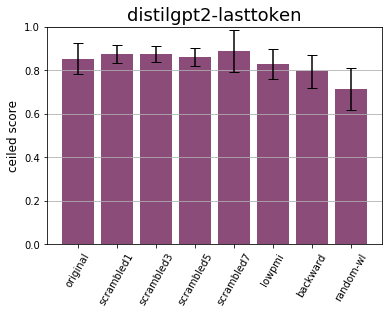

In [11]:
main_plot('distilgpt2',categories_dict,scr_perturb="scrambled")

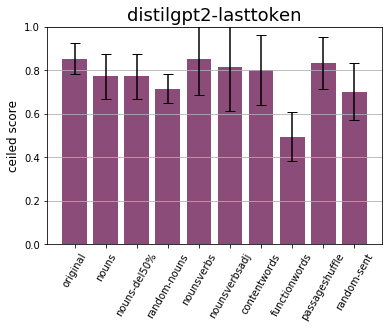

In [12]:
main_plot('distilgpt2',categories_dict,scr_perturb="perturb")

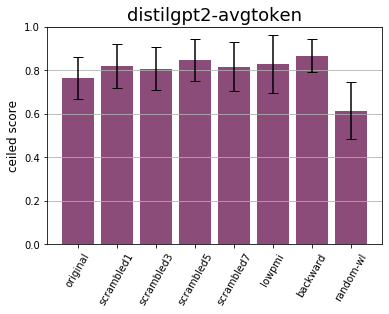

In [13]:
main_plot('distilgpt2-avgtoken',categories_dict,scr_perturb="scrambled")

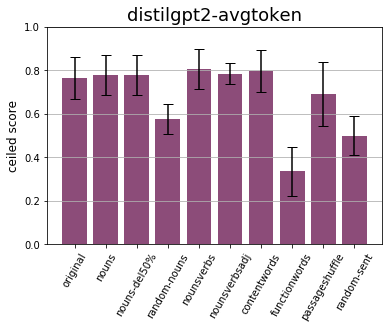

In [14]:
main_plot('distilgpt2-avgtoken',categories_dict,scr_perturb="perturb")

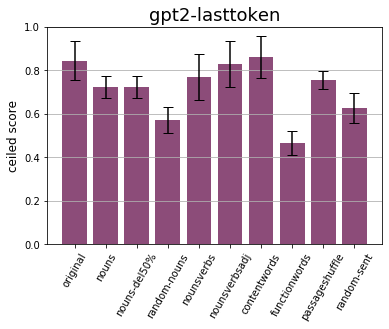

In [20]:
main_plot('gpt2',categories_dict,scr_perturb="perturb")

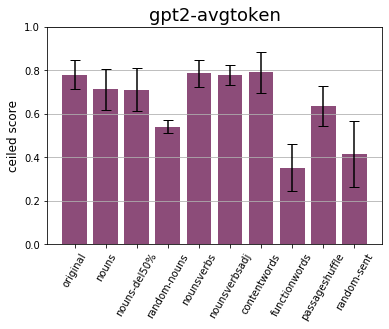

In [21]:
main_plot('gpt2-avgtoken',categories_dict,scr_perturb="perturb")

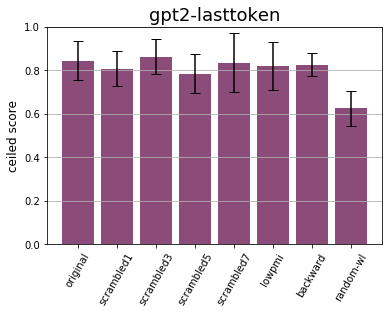

In [15]:
main_plot('gpt2',categories_dict,scr_perturb="scrambled")

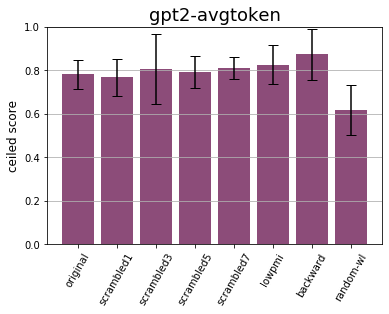

In [16]:
main_plot('gpt2-avgtoken',categories_dict,scr_perturb="scrambled")

# Loop into subplots

In [17]:
import math
from matplotlib.gridspec import GridSpec

def get_subplots_loop(model_list, scr_perturb=None):
    nsubplots = len(model_list)
    nrows = math.ceil(nsubplots/2)
    colors = sns.color_palette("rocket")
    
    fig2 = plt.figure(constrained_layout=True, figsize=(15, 4*nrows))
    #fig2.suptitle('Last-layer score across scrambling conditions', fontsize=22, y=1.05)
    spec2 = GridSpec(ncols=2, nrows=nrows, figure=fig2)
    f2_ax = []
    
    counter = 0
    for i in range(nrows):
        for j in range(2):
            if counter + 1 > nsubplots:
                break
            else:
                print(model_list[counter])
                scores_df = get_best_scores_df(model_list[counter],categories_dict,scr_perturb=scr_perturb)
                x_pos = np.arange(len(scores_df))
                scores = scores_df['score']
                errors = scores_df['error']
                conditions = scores_df['condition']

                f2_ax.append(fig2.add_subplot(spec2[i, j]))
                f2_ax[-1].bar(x_pos, scores,
                       yerr=errors,
                       align='center',
                       alpha=0.8, #color intensity
                       ecolor='black',
                       capsize=5, #error-bar width
                       color=colors[1]) #if you put just color=colors, you get the bar plots in different rocket palette colors
                f2_ax[-1].set_ylabel('ceiled score',fontsize=12)
                f2_ax[-1].set_xticks(x_pos)
                f2_ax[-1].set_xticklabels(conditions, rotation=60)
                f2_ax[-1].set_ylim([0, 1])
                
                model_name = model_list[counter]
                if len(model_name.split("-")) == 1:
                    model_name = model_name + "-lasttoken"
                f2_ax[-1].set_title('{}'.format(model_name),fontsize=18)
                f2_ax[-1].yaxis.grid(True)
                counter += 1
    fig2.savefig(f'fig/{date.today()}_match-to-brain_loop_{scr_perturb}.png', bbox_inches='tight', dpi=240)

distilgpt2
distilgpt2-avgtoken
gpt2
gpt2-avgtoken


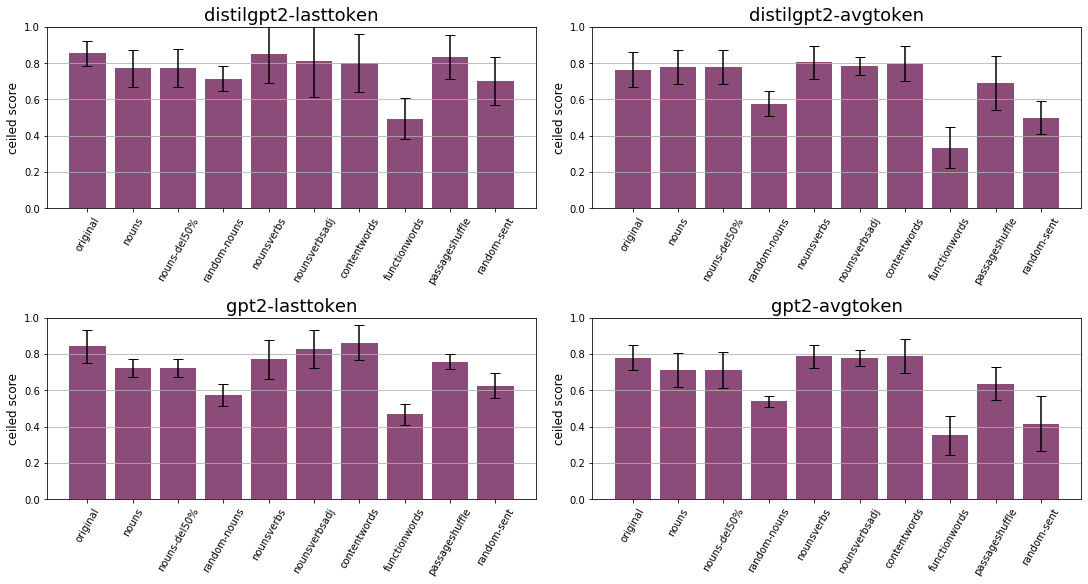

In [18]:
get_subplots_loop(['distilgpt2', 'distilgpt2-avgtoken', 'gpt2', 'gpt2-avgtoken'], scr_perturb="perturb")

distilgpt2
distilgpt2-avgtoken
gpt2
gpt2-avgtoken


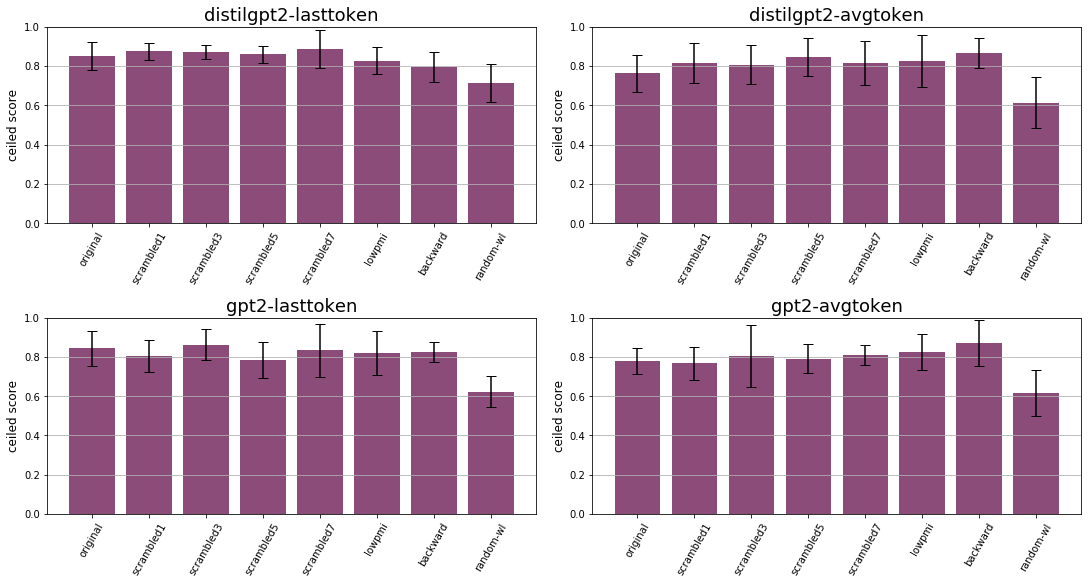

In [19]:
get_subplots_loop(['distilgpt2', 'distilgpt2-avgtoken', 'gpt2', 'gpt2-avgtoken'], scr_perturb="scrambled")